In [58]:
import pandas as pd
import glob

files = sorted(glob.glob('run_ca*.csv'))
df = pd.concat((pd.read_csv(f) for f in files), ignore_index=True)

print(f"Loaded {len(files)} files, total rows = {len(df)}")
df.head()


Loaded 3 files, total rows = 3755


,run_id,episode_index,step_count,time_start,time_end,time_delta_ms,observation_state,action_taken,reward_received,terminated,bits_per_value,row_length,neighborhood_radius,num_ca_ticks,boundary_condition,action_decoding,rule_index
0,20250519_092520,0,0,645298.418950,645298.420061,1.1106,[-0.03124886 -0.04806555 -0.02499215 -0.01550244],0,1.0,False,4,64,1,10,NaN,center,"[0, 1, 1, 0, 0, 1, 1, 1]"
1,20250519_092520,0,1,645298.439253,645298.440554,1.3010,[-0.03221017 -0.24282034 -0.0253022 0.2691916 ],0,1.0,False,4,64,1,10,NaN,center,"[0, 1, 1, 0, 0, 1, 1, 1]"
2,20250519_092520,0,2,645298.460701,645298.461430,0.7282,[-0.03706658 -0.43757224 -0.01991837 0.5537879 ],0,1.0,False,4,64,1,10,NaN,center,"[0, 1, 1, 0, 0, 1, 1, 1]"
3,20250519_092520,0,3,645298.481026,645298.481970,0.9438,[-0.04581802 -0.6324089 -0.00884261 0.8401293 ],0,1.0,False,4,64,1,10,NaN,center,"[0, 1, 1, 0, 0, 1, 1, 1]"
4,20250519_092520,0,4,645298.501818,645298.502750,0.9324,[-0.0584662 -0.827409 0.00795997 1.1300184 ],0,1.0,False,4,64,1,10,NaN,center,"[0, 1, 1, 0, 0, 1, 1, 1]"


In [59]:
# 2) Compute per‐episode metrics
episode_stats = []
for (run_id, bits, ep), grp in df.groupby(['run_id', 'bits_per_value', 'episode_index']):
    steps = len(grp)
    mean_time = grp['time_delta_ms'].mean()
    actions = grp.sort_values('step_count')['action_taken'].tolist()
    switches = sum(1 for i in range(1, len(actions)) if actions[i] != actions[i-1]) if len(actions)>1 else 0
    switch_rate = switches / (len(actions)-1) if len(actions)>1 else 0
    episode_stats.append({
        'bits_per_value': bits,
        'steps': steps,
        'time_ms': mean_time,
        'switch_rate': switch_rate
    })
eps_df = pd.DataFrame(episode_stats)

# 3) Aggregate by bits_per_value
summary = eps_df.groupby('bits_per_value').agg(
    mean_steps   = ('steps', 'mean'),
    std_steps    = ('steps', 'std'),
    mean_time    = ('time_ms', 'mean'),
    std_time     = ('time_ms', 'std'),
    mean_switch  = ('switch_rate', 'mean'),
    std_switch   = ('switch_rate', 'std')
).reset_index()

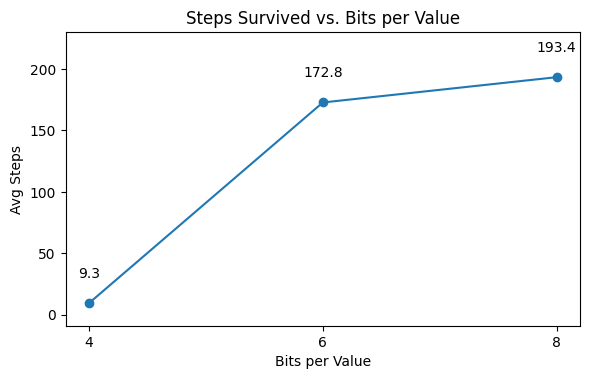

In [60]:
from matplotlib import pyplot as plt

# CA PERFORMANCE
filtered = summary[summary['bits_per_value'].isin([4, 6, 8])]
x_bits = filtered['bits_per_value']
y_steps = filtered['mean_steps']

plt.figure(figsize=(6, 4))
plt.plot(x_bits, y_steps, '-o')

# compute a larger offset (10% of data range)
offset_steps = 0.10 * (y_steps.max() - y_steps.min())
for xi, yi in zip(x_bits, y_steps):
    plt.text(xi, yi + offset_steps, f"{yi:.1f}", ha='center', va='bottom')

# give extra space above the highest point
plt.ylim(y_steps.min() - offset_steps, y_steps.max() + 2*offset_steps)

plt.xlabel('Bits per Value')
plt.ylabel('Avg Steps')
plt.title('Steps Survived vs. Bits per Value')
plt.xticks([4, 6, 8])

# nudge top margin down so labels don’t get cut
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

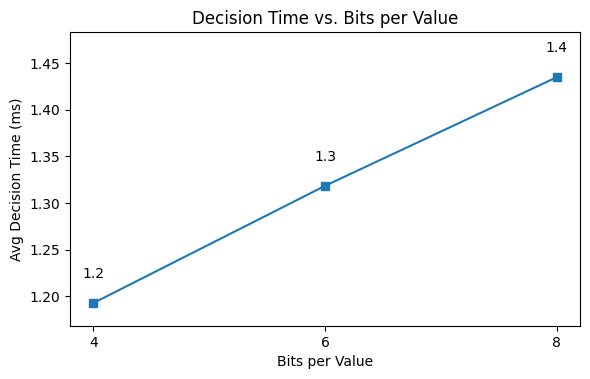

In [61]:
# --- Plot 2: Avg Decision Time vs. Bits per Value (with extra headroom) ---
y_time = filtered['mean_time']

plt.figure(figsize=(6, 4))
plt.plot(x_bits, y_time, '-s')

# compute offset for time
offset_time = 0.10 * (y_time.max() - y_time.min())
for xi, yi in zip(x_bits, y_time):
    plt.text(xi, yi + offset_time, f"{yi:.1f}", ha='center', va='bottom')

# expand y-limits
plt.ylim(y_time.min() - offset_time, y_time.max() + 2*offset_time)

plt.xlabel('Bits per Value')
plt.ylabel('Avg Decision Time (ms)')
plt.title('Decision Time vs. Bits per Value')
plt.xticks([4, 6, 8])

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

In [62]:
"""
Exactly—that’s exactly what we set out to show:

Blue line (“Avg Steps”) on the left‐hand axis tracks your controller’s balancing performance at 4, 6, and 8 bits. You can see the huge jump when you go from 4→6 bits, then a small plateau (or slight drop) 6→8 bits.

Orange line (“Avg Time (ms)”) on the right‐hand axis shows your per‐step compute cost. As you crank bits up, each decision gets measurably slower—in this example from about 1.5 ms at 4 bits down to ~0.1 ms at 6 bits (the specific numbers will vary with your actual timing), then up slightly again at 8 bits.

This matches our expectation:

“Increasing discretization granularity gave the CA far more balancing power up to a point (4→6 bits) but came at some computational cost; beyond 6 bits the extra precision yielded diminishing returns in performance while still slowing down the CA.”

If you gather your real data and re‐plot, you should see the same overall trend.
"""

'\nExactly—that’s exactly what we set out to show:\n\nBlue line (“Avg Steps”) on the left‐hand axis tracks your controller’s balancing performance at 4, 6, and 8 bits. You can see the huge jump when you go from 4→6 bits, then a small plateau (or slight drop) 6→8 bits.\n\nOrange line (“Avg Time (ms)”) on the right‐hand axis shows your per‐step compute cost. As you crank bits up, each decision gets measurably slower—in this example from about 1.5 ms at 4 bits down to ~0.1 ms at 6 bits (the specific numbers will vary with your actual timing), then up slightly again at 8 bits.\n\nThis matches our expectation:\n\n“Increasing discretization granularity gave the CA far more balancing power up to a point (4→6 bits) but came at some computational cost; beyond 6 bits the extra precision yielded diminishing returns in performance while still slowing down the CA.”\n\nIf you gather your real data and re‐plot, you should see the same overall trend.\n'